# Advanced Lane Finding 


Stages:

0. Calculate Camera Calibration Matrix

Pipeline Stages:
1. Apply Distortion Correction
2. Perform appropriate colour transformations 
3. Adjust perspective to get Bird's Eye View
4. Perform Lane Detection
5. Calculate curvature
6. Warp back to original image
7. Output Image

0 is a pre-processing step, while 1-7 indicate our processing pipeline

In [1]:
## Import Libraries

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
# Calculate Camera Distortion Matrix

# This is performed in a seperate notebook and the numbers brought in.
dist_pickle = pickle.load( open( "cameracal.p", "rb" ) )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# undist = cv2.undistort(img, mtx, dist, None, mtx)

In [3]:
# Pipeline Steps

# 1 Distortion
def pipeline_undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [85]:
# 2 Colour Transform

def pipeline_colourtransform(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    # Set Threshold and create output
    thresh = (0, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 255
    
    # S is a good channel for lines but R is sometimes better on white lines. 
    # You could take S channel + R channel where colour is near White?
    
    # Take the saturation channel only
    return binary

In [86]:
# 3 Perspective transform to Bird's Eye

# Initially calculate the transforms
xsize = 1280
ysize = 720
    
# Points are TL, TR, BL, BR
src = np.float32([[598,445],[683,445],[272,675],[1052,675]])
dst = np.float32([[200,0],[xsize-200,0],[200,ysize],[xsize-200,ysize]])
    
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src) 

def pipeline_perspectivetransform(img):
    return cv2.warpPerspective(img, M, (xsize,ysize), flags=cv2.INTER_LINEAR)

def pipeline_inverttransform(img):
    return cv2.warpPerspective(img, Minv, (xsize,ysize), flags=cv2.INTER_LINEAR)

In [87]:
#6 Calculate Curvature

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

NameError: name 'generate_data' is not defined

In [88]:
# PipeLine

def pipeline(img):
    
    # 2 Distortion - use previously calculated camera calibration
    img = pipeline_undistort(img)
    
    # 3 Colour Transforms
    img = pipeline_colourtransform(img)
    
    img = combined_sobel(img)
    
    
    
    # 4 Adjust to Bird's Eye
    img = pipeline_perspectivetransform(img)
    
    # 5 Lane Detection
    # Run image through the pipeline
    # Note that in your project, you'll also want to feed in the previous fits
   # warped = search_around_poly(warped)

    # View your output
    
    # 6 Calculate Curvature
    

    # 7 Warp back to Original
    #img = pipeline_inverttransform(img)
    
    #img = warped
    
    # 8 return image
    return img
    

Having completed the pipeline now lets test in on the TEST IMAGES

test5.jpg


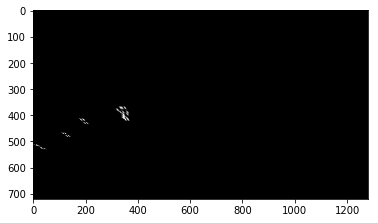

test6.jpg


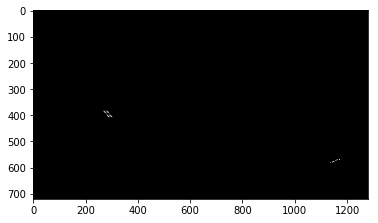

straight_lines2.jpg


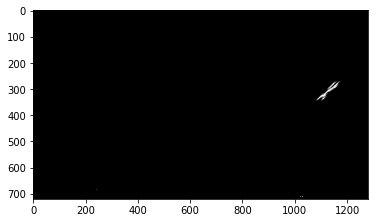

straight_lines1.jpg


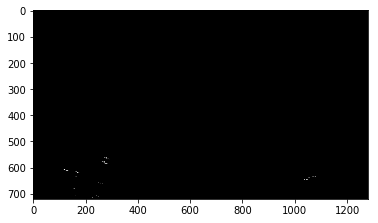

test3.jpg


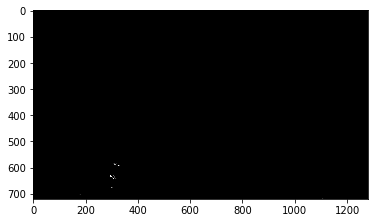

test4.jpg


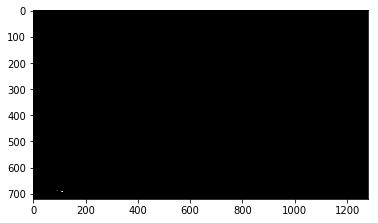

test1.jpg


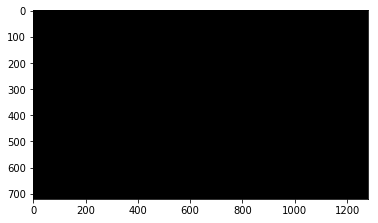

test2.jpg


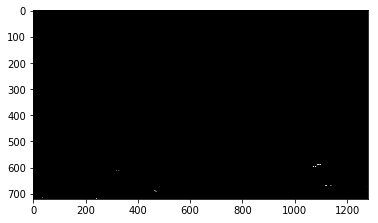

In [93]:
# Run Pipeline on all the TEST Images

for i, filename in enumerate(os.listdir("test_images/")):
      
    # Load Image and process
    print(filename)
    image = mpimg.imread("test_images/" + filename)
    outimage = pipeline(image)
    # Save Image
    #cv2.imwrite('output_images/' + filename, cv2.cvtColor(outimage, cv2.COLOR_RGB2BGR))
    plt.imshow(outimage, cmap='gray')
    plt.show()

So we don't make the pipeline too large and complicated a block of code, the cell below contains the functions necessary for finding the lanes


In [92]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = image
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Convert to grayscale
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = image
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Grayscale
    gray = image
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_sobel(img):
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', thresh_min = 20, thresh_max = 100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min = 20, thresh_max = 100)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((mag_binary ==1) & (dir_binary==1))] =1
    
    return combined

In [ ]:
# These are the functions to find the lines using a sliding window 

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

